## Interpolating HEALPix GRIB fields

This example shows how to interpolate GRIB data defined on a HEALPix nested grid. We will also see how to inspect and plot the resulting data and how to convert it to xarray.

To make this notebook work **earthkit.data** and **earthkit.maps** have to be installed. The data will be represented as an [earthkit-data GRIB FieldList](https://earthkit-data.readthedocs.io/en/latest/guide/data_format/grib.html).

#### Interpolation

In [1]:
import os
from earthkit.regrid import interpolate
from earthkit.data import from_source, FieldList

# Get HEALPix nested GRIB data containing two fields.
ds = from_source(
    "url", 
    "https://get.ecmwf.int/repository/test-data/earthkit-regrid/examples/H8_nested_multi.grib2")

# the target grid is a global 5x5 degree regular latitude grid
target_gridspec = {"grid": [5,5]}

# perform interpolation for each field and add results 
# to a new fieldlist stored in memory
r = FieldList()
for f in ds:
    v_res = interpolate(f.to_numpy(flatten=True), f.metadata().gridspec, target_gridspec,
                       method="linear")
    md_res = f.metadata().override(gridspec=target_gridspec)
    r += ds.from_numpy(v_res, md_res)

d = r.data()
lat = d[0]
lon = d[1]
vals = d[2:]
lat.shape, lon.shape, vals.shape

((37, 72), (37, 72), (2, 37, 72))

#### Plotting the results

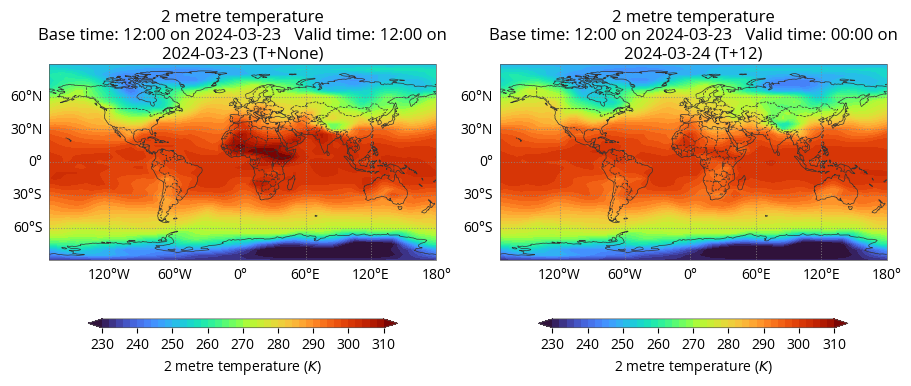

In [2]:
import earthkit.maps
earthkit.maps.quickplot(r)

#### Converting the results to xarray

In [3]:
r.to_xarray()

<xarray.Dataset>
Dimensions:            (time: 1, step: 2, heightAboveGround: 1, latitude: 37,
                        longitude: 72)
Coordinates:
  * time               (time) datetime64[ns] 2024-03-23T12:00:00
  * step               (step) timedelta64[ns] 00:00:00 12:00:00
  * heightAboveGround  (heightAboveGround) float64 2.0
  * latitude           (latitude) float64 90.0 85.0 80.0 ... -80.0 -85.0 -90.0
  * longitude          (longitude) float64 0.0 5.0 10.0 ... 345.0 350.0 355.0
    valid_time         (time, step) datetime64[ns] ...
Data variables:
    t2m                (time, step, heightAboveGround, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T19:54 GRIB to CDM+CF via cfgrib-0.9.1...

#### Writing the results to disk

Write the resulting fieldlist to disk:

In [4]:
out_file = "_res_H8_nested_to_5x5.grib"
r.save(out_file)

If we do not want to store the resulting fieldlist in memory we can write each field to disk as soon as it is created.

In [5]:
# ensure the output does not exist
if os.path.exists(out_file):
    os.remove(out_file)
    
for f in ds:
    v_res = interpolate(f.to_numpy(), f.metadata().gridspec, target_gridspec)
    md_res = f.metadata().override(gridspec=target_gridspec)
    FieldList.from_numpy(v_res, md_res).save(out_file, append=True)

We can then read the data from disk as a fieldlist with lazy memory loading. This fieldlist can be used for inspection, plotting and xarray conversion in the same way as shown above.

In [6]:
ds1 = from_source("file", out_file)
ds1.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20240323,1200,0,fc,None,regular_ll
1,ecmf,2t,heightAboveGround,2,20240323,1200,12,fc,None,regular_ll


In [7]:
d = ds1.data()
d.shape

(4, 37, 72)